In [1]:
import numpy as np
import os , sys
sys.path.append("..")

In [2]:
from Gen_src.diffusion import GaussianDiffusion1D
from Gen_src.model import Unet1D
import torch
import os,sys
# Add the parent directory of Gen_src to sys.path
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))
import torch
import os

# Same architecture as in training
model = Unet1D(
    dim=32,
    dim_mults=(2, 4, 8, 16),
    channels=2,  # X and Y
    dropout=0.1
).cuda()  # or .to(device)

# Create the same diffusion wrapper
diffusion = GaussianDiffusion1D(
    model,
    seq_length=192,      # must match your training setup
    objective='pred_noise',
    timesteps=1000,
    auto_normalize=False
).cuda()  # or .to(device)

# Load checkpoint
checkpoint_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths/dpp_0.1_autonorm_true_200_epoch/model_epoch_200.pt"
model.load_state_dict(torch.load(checkpoint_path))
model.eval()
print("Loaded model weights from:", checkpoint_path)


/home/bardiya/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/../Gen_src/diffusion.py:331: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


Loaded model weights from: /home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths/dpp_0.1_autonorm_true_200_epoch/model_epoch_200.pt


/tmp/ipykernel_3824/4073076511.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


In [3]:
from pathlib import Path

DATA_DIR = Path(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw")
coord_mm = np.load(DATA_DIR/"coord_min_max.npy")  # [[x_min,y_min],[x_max,y_max]]
x_min,y_min = coord_mm[0]; x_max,y_max = coord_mm[1]

def inv_coords(xs_s):                   # xs_s shape (...,2,192) tensor
    xs_np = xs_s.permute(0,2,1).cpu().numpy()    # -> (B,192,2)
    xs_np[...,0] = xs_np[...,0]*(x_max-x_min) + x_min
    xs_np[...,1] = xs_np[...,1]*(y_max-y_min) + y_min
    return xs_np                                # (B,192,2) numpy


In [4]:
num_to_generate = 128
batch_size      = 128

# generated_scaled = []
# latent = torch.randn((1,2,192)).to("cuda")
# samples1 = diffusion.latent_sample(latent , is_ddim=True)
# samples2 = diffusion.latent_sample(latent , is_ddim=True)
# generated_samples1 = inv_coords(samples1)
# generated_samples2 = inv_coords(samples2)


all_latent = []
all_shapes = []
with torch.no_grad():
    done = 0
    while done < num_to_generate:
        cur = min(batch_size, num_to_generate - done)
        
        latent = torch.randn((cur,2,192)).to("cuda")
        samples = diffusion.latent_sample(latent , is_ddim=True)
        generated_real = inv_coords(samples)
        
        all_latent.append(latent.cpu().detach().numpy())
        all_shapes.append(generated_real)
        done += cur
        print(f"Generated {done}/{num_to_generate}")

sampling loop time step: 100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


Generated 128/128


In [5]:
generated_real.shape

(128, 192, 2)

In [6]:
# ================================================================
#  Sanity - pattern and t-SNE on inverse-scaled results
# ================================================================
import numpy as np, matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -------- helper to draw mean ± std signature -------------------
def plot_signature(xs, name):
    xs = np.asarray(xs)                      # (N,192,2)
    mean_x, std_x = xs[...,0].mean(0), xs[...,0].std(0)
    mean_y, std_y = xs[...,1].mean(0), xs[...,1].std(0)
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].plot(mean_x); ax[0].fill_between(range(192), mean_x-std_x, mean_x+std_x, alpha=.2)
    ax[0].set_title(f"{name} X mean±std")
    ax[1].plot(mean_y, color='orange'); ax[1].fill_between(range(192), mean_y-std_y, mean_y+std_y, alpha=.2,color='orange')
    ax[1].set_title(f"{name} Y mean±std")
    plt.tight_layout(); plt.show()
    
# # transpose generated_real to (N,192,2) if not already
# gen_xyz = generated_real                     # (9701,192,2)

# print("=== Point-wise signature comparison ===")
# plot_signature(gen_xyz,           "Generated")
# plot_signature(xs_train,          "Train")
# plot_signature(xs_test,           "Test")

# # # -------- t-SNE settings ----------------------------------------
# USE_TRAIN_AS_REAL = False          # set True to compare with train set

# real_set   = xs_train if USE_TRAIN_AS_REAL else xs_test
# real_label = "Train" if USE_TRAIN_AS_REAL else "Test"


xs_test.shape=(9701, 192, 2)
xs_train.shape=(38802, 192, 2)


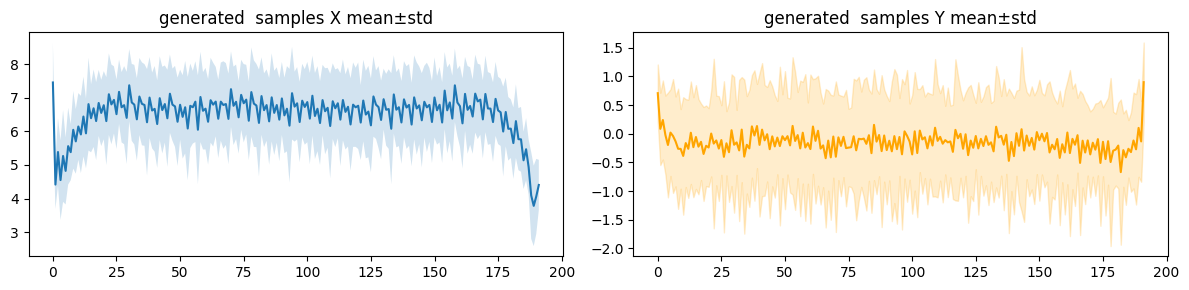

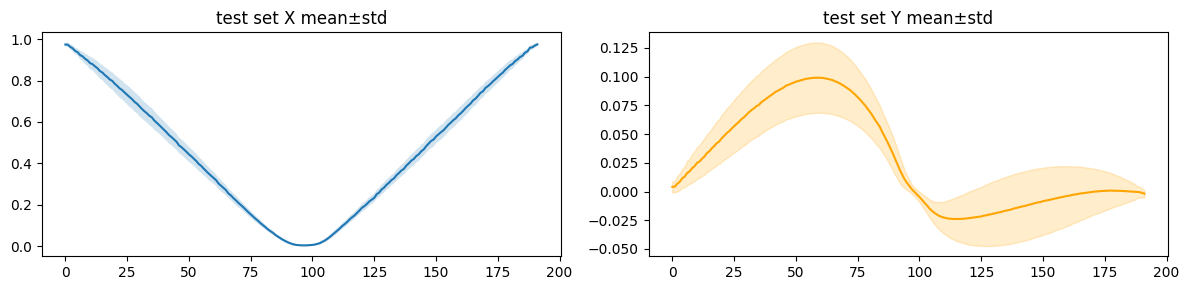

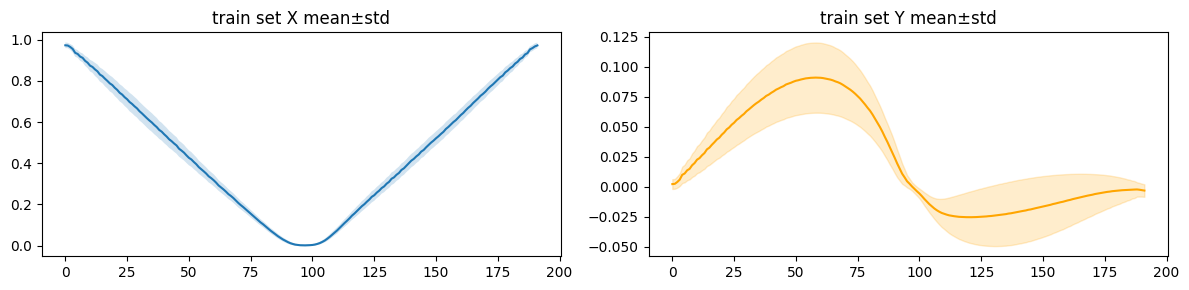

In [7]:
xs_test = np.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy")
xs_train = np.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy")
print(f"{xs_test.shape=}")
print(f"{xs_train.shape=}")

plot_signature(generated_real, "generated  samples")
plot_signature(xs_test, "test set")
plot_signature(xs_train, "train set")